In [1]:
from astropy.table import Table
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse

W51 = '/orange/adamginsburg/w51/TaehwaYoo/'
W51b6 = '/orange/adamginsburg/w51/TaehwaYoo/2015.1.01596.S_W51_B6_LB/continuum_images/'
W51cont='/orange/adamginsburg/w51/TaehwaYoo/b6contfits/'
w51e2_b6_briggs=W51cont+'W51e2_cont_bigbriggs.image.fits'
w51e2_b6_robust0=W51cont+'W51e2_cont_big_robust0.image.fits'
w51e2_b6_uniform=W51cont+'W51e2_cont_biguniform.image.fits'
w51e2_b6_superuniform=W51cont+'W51e2_cont_bigsuperuniform.image.fits'

w51n_b6_briggs = W51cont+'W51n_cont_bigbriggs.image.fits'
w51n_b6_robust0 = W51cont+'w51n_cont_big_robust0.image.fits'
w51n_b6_uniform = W51cont+'W51n_cont_biguniform.image.fits'
w51n_b6_superuniform = W51cont+'W51n_cont_bigsuperuniform.image.fits'
w51n_b6_natural = W51cont+'W51n_cont_bignatural.image.fits'

W51b3 = '/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/'

w51n_b3_tt0 = W51b3+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51n_b3_tt1 = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51n_b3_alpha = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51conv = '/orange/adamginsburg/w51/TaehwaYoo/convolved_new/'
w51n_b6_conv = w51conv + 'w51n_cont_bigbriggs.image.convB3_briggs.fits'

w51e2_b3_tt0 = W51b3+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51e2_b3_tt1 = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51e2_b3_alpha = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51e2_b6_conv = w51conv + 'w51e2_cont_bigbriggs.image.convB3_briggs.fits'

w51e_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B6_conv.fits'
w51e_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B3_conv.fits'


w51n_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B3_conv.fits'

w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'

w51n_b6_conv_briggs = w51conv + 'w51n_briggs_B6_conv.fits'
w51n_b6_conv_robust0 = w51conv + 'w51n_robust0_B6_conv.fits'
w51n_b6_conv_superuniform = w51conv + 'w51n_superuniform_B6_conv.fits'


#w51n_b6_conv_briggs = '/Users/dbahck37/w51data/convolved_new/w51n_briggs_B6_conv.fits'
#w51n_b3_tt0 = '/Users/dbahck37/w51data/w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'




In [2]:
def measure_alpha_peak_matching(b3data, b6data, tb3, tb6, b3ind, b6ind,  save=True, savedir=None):
    peakx_b6 = list(tb6['peak_x'])
    peaky_b6 = list(tb6['peak_y'])
    peakxy_b6 = np.vstack((peakx_b6,peaky_b6)).T


    peakx_b3 = list(tb3['peak_x'])
    peaky_b3 = list(tb3['peak_y'])
    peakxy_b3 = np.vstack((peakx_b3,peaky_b3)).T

    fitsdata_b3 = fits.open(b3data)
    imageb3 = fitsdata_b3[0].data
    if len(imageb3.shape)!=2:
        imageb3 = imageb3[0][0]
    
    fitsdata_b6 = fits.open(b6data)
    imageb6 = fitsdata_b6[0].data
    if len(imageb6.shape)!=2:
        imageb6 = imageb6[0][0]

    hdrNB6 = fits.getheader(b6data)  
    hdrNB3 = fits.getheader(b3data)  
    wcsNB3 = WCS(hdrNB3,naxis=2)
    wcsNB6 = WCS(hdrNB6,naxis=2)
    
    my_beamNB6 = Beam.from_fits_header(hdrNB6)
    my_beamNB3 = Beam.from_fits_header(hdrNB3)


    scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
    scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]

    scaleNB3_sr = (scaleNB3 * np.pi/180)**2
    scaleNB6_sr = (scaleNB6 * np.pi/180)**2


    
    
    

    B6flux = get_flux(imageb6,peakxy_b6[b6ind], my_beamNB6,  wcsNB6, scaleNB6)
    B3flux = get_flux(imageb3,peakxy_b3[b3ind], my_beamNB3,  wcsNB3, scaleNB3)
  
    freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])

    freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])
    alpha = np.log10(B3flux/B6flux)/np.log10(freqb3/freqb6)
    print(alpha)
    
    return alpha

def get_flux(data,peakxy, beam1, wcsNB, pixel_scale, issky=False,savedir=None):
    fluxarr = []

    if issky:
        print(issky)
        cen_world = peakxy
    else:
        print(issky)
        cen_world = wcsNB.wcs_pix2world(peakxy,0)
    num_source = len(cen_world)
    print('cen_world',cen_world,len(cen_world))
    print(num_source)
    
    for i in range(num_source):
        
        #x_cen = peakxy[i][0]
        #y_cen = peakxy[i][1]
        #cen = (x_cen, y_cen)
        major = beam1.major
        minor = beam1.minor
        pa = beam1.pa
      
        positions = coordinates.SkyCoord(cen_world[i,0],cen_world[i,1], frame=wcs.utils.wcs_to_celestial_frame(wcsNB).name,unit=(u.deg,u.deg))
        cutout = Cutout2D(data, positions, 4.0*major, wcs=wcsNB, mode='partial')
        print(positions, major, cutout.data)
        frame = wcs.utils.wcs_to_celestial_frame(cutout.wcs).name
        aperture = Ellipse(positions, major, minor, -1*pa, unit=u.deg, frame=frame) # pa in degree with anti-clockwise direction
        this_mask = aperture.place(cutout.data, wcs=cutout.wcs)
        pixel_scale_sr = (pixel_scale.value * np.pi/180)**2 # pixel scale in deg^2 -> sr
        fluxarr.append(np.sum(cutout.data[this_mask]/beam1.sr.value*pixel_scale_sr)) # Jy/beam / (sr/beam) * (sr/pixel) = Jy/ pixel
        if savedir is not None:
            fig = plt.figure(figsize=(10,10))
            ax1=fig.add_axes([0.2,0.2,0.8,0.8],projection=wcsNB)
            ax1.imshow(cutout.data, origin='lower')
            ax1.imshow(this_mask, origin='lower',alpha=0.1,cmap='gray')
            plt.savefig(savedir+'aper_%04d.png'%i)
            plt.close()
    return np.array(fluxarr) 

def cen_freq(center, delta ,alpha=2):
    start = center-delta/2 ; end = center+delta/2
    freqarr = np.logspace(np.log10(start),np.log10(end),20)
    dfreq = freqarr[1:]-freqarr[:-1]
    dfreq = np.append(dfreq,[dfreq[-1]])
    
    integral_up = np.sum(freqarr**(alpha+1)*dfreq)
    integral_down = np.sum(freqarr**(alpha)*dfreq)
    return integral_up/integral_down






def alpha_from_skycoord_match(b3data, b6data, xpos, ypos, error=None, isb3=True):
  
    fitsdata_b3 = fits.open(b3data)
    imageb3 = fitsdata_b3[0].data
    if len(imageb3.shape)!=2:
        imageb3 = imageb3[0][0]
    
    fitsdata_b6 = fits.open(b6data)
    imageb6 = fitsdata_b6[0].data
    if len(imageb6.shape)!=2:
        imageb6 = imageb6[0][0]
        
  
    hdrNB6 = fits.getheader(b6data)  
    hdrNB3 = fits.getheader(b3data)  
    wcsNB3 = WCS(hdrNB3,naxis=2)
    wcsNB6 = WCS(hdrNB6,naxis=2)
    
    my_beamNB6 = Beam.from_fits_header(hdrNB6)
    my_beamNB3 = Beam.from_fits_header(hdrNB3)


    scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
    scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
    
    if type(xpos) is not list:
        num_source = 1
    else:
        num_source = len(xpos)

    if isb3:
        peakxy_b3 = np.vstack((xpos,ypos)).T
        B3flux = get_flux(imageb3,peakxy_b3, my_beamNB3, wcsNB3,scaleNB3)
        peaksky = wcsNB3.pixel_to_world(xpos,ypos)
        peaksky_ra = [] ; peaksky_dec = []

        for i in range(num_source):
            if num_source==1:
                peaksky_ra.append(peaksky.ra.degree)
                peaksky_dec.append(peaksky.dec.degree)
            else:
                peaksky_ra.append(peaksky[i].ra.degree)
                peaksky_dec.append(peaksky[i].dec.degree)
        peaksky_arr = np.vstack((peaksky_ra,peaksky_dec)).T
        B6flux = get_flux(imageb6,peaksky_arr, my_beamNB6, wcsNB6,scaleNB6,issky=True)
        lowind = np.where(B6flux < error)[0]
        B6flux[lowind] = error
    else:
        peakxy_b6 = np.vstack((xpos,ypos)).T
        B6flux = get_flux(imageb6,peakxy_b6, my_beamNB6, wcsNB6,scaleNB6)
        peaksky = wcsNB6.pixel_to_world(xpos,ypos)
        peaksky_ra = [] ; peaksky_dec = []
        for i in range(num_source):
            if num_source==1:
                peaksky_ra.append(peaksky.ra.degree)
                peaksky_dec.append(peaksky.dec.degree)
            else:
                peaksky_ra.append(peaksky[i].ra.degree)
                peaksky_dec.append(peaksky[i].dec.degree)
        peaksky_arr = np.vstack((peaksky_ra,peaksky_dec)).T
        B3flux = get_flux(imageb3,peaksky_arr, my_beamNB3, wcsNB3,scaleNB3,issky=True)
        lowind = np.where(B3flux < error)[0]
        B3flux[lowind] = error
    freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
    freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])
    alpha = np.log10(B3flux/B6flux)/np.log10(freqb3/freqb6)
    
    print(B3flux, B6flux, freqb3,freqb6)
    print(alpha)

    
    return alpha





matching_index
--------------
        930000
        930001
        930002
        930006
        930025
        930034
           ...
        930054
        930063
        930064
        930060
        930066
        930076
Length = 21 rows
[]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] [0, 1, 2, 3, 4, 7, 6, 8, 5, 9, 11, 10, 15, 13, 14, 16, 18, 19, 17, 20, 21]
[ 0.11028999  0.12591644  0.03208781 -0.046108    0.04771356  0.14154034
  0.04771296  0.11026313  0.14153877  0.20408824  0.17281417  0.00079695
  0.11025834  0.15717341  0.11026002  0.07898376  0.09462018  0.07898215
  0.11025748  0.15717011  0.04770118]


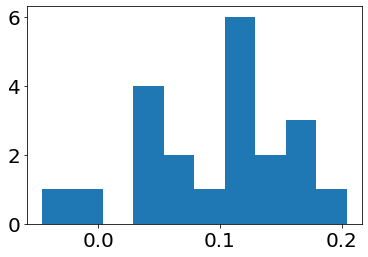

In [3]:
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
w51n_b3 = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51n_b3.fits',format='fits')
w51n_b6 = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51n_b6_briggs.fits',format='fits')
#w51n_b3 = Table.read('/Users/dbahck37/w51_jupyter/w51/catalogue/dendrogram/dendro_w51n_b3.fits',format='fits')
#w51n_b6 = Table.read('/Users/dbahck37/w51_jupyter/w51/catalogue/dendrogram/dendro_w51n_b6_briggs.fits',format='fits')
b6matind_table = w51n_b6['matching_index']
b3matind_table = w51n_b3['matching_index']
b6indic = w51n_b6['_name']
b3indic = w51n_b3['_name']
b6matched = [i for i in range(len(b6matind_table)) if int(b6matind_table[i])>0]
b6matind_table_matched = b6matind_table[b6matched]

b3matched = [i for i in range(len(b3matind_table)) if int(b3matind_table[i])>0]
b3matind_table_matched = b3matind_table[b3matched]
print(b6matind_table)
b3matchindlist=[]
for ind in b6matind_table_matched:
    b3matchind = np.where(ind==b3indic)[0]
    b3matchindlist.append(b3matchind.item())
# find unselected index
"""
b3_unselected = list(np.arange(len(b3indic)))
for ind in b3matchindlist:
    b3_unselected.remove(ind)
"""

b3_unselected = [i for i in range(len(b3matind_table)) if int(b3matind_table[i])<0]

b6matchindlist = []

for ind in b3matind_table_matched:
    b6matchind = np.where(ind==b6indic)[0]
    if len(b6matchind)==0:
        continue
    b6matchindlist.append(b6matchind.item())
print(b6matchindlist)

# find unselected index
"""
b6_unselected = list(np.arange(len(b6indic)))
for ind in b6matchindlist:
    b6_unselected.remove(ind)
"""
b6_unselected = [i for i in range(len(b6matind_table)) if int(b6matind_table[i])<0]




hdrNB6 = fits.getheader(w51n_b6_conv_briggs)  
hdrNB3 = fits.getheader(w51n_b3_tt0)  
wcsNB3 = WCS(hdrNB3,naxis=2)
wcsNB6 = WCS(hdrNB6,naxis=2)


peakx_b6 = list(w51n_b6['peak_x'])
peaky_b6 = list(w51n_b6['peak_y'])
peakxy_b6 = np.vstack((peakx_b6,peaky_b6)).T

cen_world_b6 = wcsNB6.wcs_pix2world(peakxy_b6,0)



peakx_b3 = list(w51n_b3['peak_x'])
peaky_b3 = list(w51n_b3['peak_y'])
peakxy_b3 = np.vstack((peakx_b3,peaky_b3)).T

cen_world_b3 = wcsNB3.wcs_pix2world(peakxy_b3,0)
print(b6matched, b3matchindlist)
radiff = cen_world_b6[b6matched,0] - cen_world_b3[b3matchindlist,0]
decdiff = cen_world_b6[b6matched,1] - cen_world_b3[b3matchindlist,1]

my_beamNB3 = Beam.from_fits_header(hdrNB3)
#b3tob6ind=np.array([0,1,2,3,4,5,8,7,9,6,10,11,12,13,14,16,17,18,15,20,19,21])
plt.hist(radiff/my_beamNB3.major.value)
print(radiff/my_beamNB3.major.value)



(array([2., 1., 0., 2., 3., 9., 2., 0., 1., 1.]),
 array([0.01513045, 0.04540463, 0.0756788 , 0.10595298, 0.13622716,
        0.16650133, 0.19677551, 0.22704969, 0.25732386, 0.28759804,
        0.31787221]),
 <BarContainer object of 10 artists>)

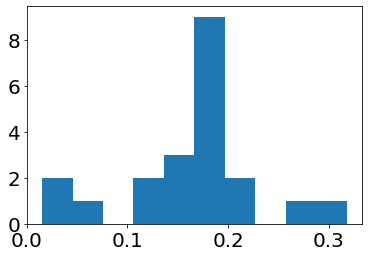

In [4]:
plt.hist(decdiff/my_beamNB3.major.value)

False
cen_world [[290.91465409  14.51760138]
 [290.91495968  14.5178236 ]
 [290.91711316  14.51789722]
 [290.91590658  14.5180125 ]
 [290.9155106   14.51810416]
 [290.91563685  14.5181125 ]
 [290.91618347  14.51812917]
 [290.91648189  14.51815417]
 [290.91595823  14.51814444]
 [290.9168793   14.51819306]
 [290.9168004   14.51816111]
 [290.91606009  14.51817222]
 [290.91700412  14.51825278]
 [290.91560098  14.51821389]
 [290.91680326  14.51822083]
 [290.91707586  14.5182375 ]
 [290.91660815  14.51825694]
 [290.91707586  14.51826806]
 [290.91715477  14.51827361]
 [290.91662536  14.51828333]
 [290.91665549  14.51836806]] 21
21
<SkyCoord (ICRS): (ra, dec) in deg
    (290.91465409, 14.51760138)> 1.834915743934e-05 deg [[-5.99383347e-05 -2.61243440e-05  5.56322993e-06 ... -2.47184304e-04
  -3.24796245e-04 -3.92963935e-04]
 [-8.91688178e-05 -6.13486700e-05 -3.13280725e-05 ... -1.99236849e-04
  -2.76815757e-04 -3.45267064e-04]
 [-9.50401809e-05 -7.45165089e-05 -4.83708536e-05 ... -1.38250703e-

Text(0.5, 0, 'spectral index')

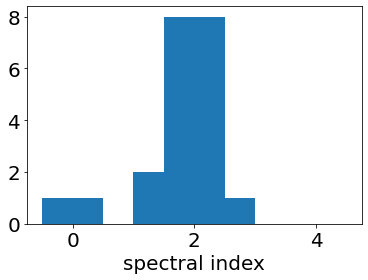

In [5]:

alpha = measure_alpha_peak_matching(w51n_b3_tt0, w51n_b6_conv_briggs,w51n_b3,w51n_b6, b3matchindlist,b6matched)
print(len(alpha))
plt.hist(alpha, bins=np.linspace(-0.5,4.5, num=11))
plt.xlabel('spectral index')




In [6]:
def save_matched_catalog(b3data,b6data,peakx_b3,peaky_b3,
                         peakx_b6,peaky_b6,
                         b3unselected, b6unselected,b3ind,b6ind,B3error,B6error,alpha):
    
    xpos_unselected_b3 = np.array(peakx_b3)[b3unselected] 
    ypos_unselected_b3 = np.array(peaky_b3)[b3unselected]
    
    xpos_unselected_b6 = np.array(peakx_b6)[b6unselected] 
    ypos_unselected_b6 = np.array(peaky_b6)[b6unselected]

    x_pix_b3 = np.array(peakx_b3)[b3ind]
    x_pix_b3 = list(x_pix_b3)
    x_pix_b3 = x_pix_b3+list(xpos_unselected_b3)
    y_pix_b3 = np.array(peaky_b3)[b3ind]
    y_pix_b3 = list(y_pix_b3)
    y_pix_b3 = y_pix_b3 + list(ypos_unselected_b3)
    print(len(b3ind),len(b3unselected))
    print(len(b6ind),len(b6unselected))

    xy_pix_b3 = np.vstack((x_pix_b3,y_pix_b3)).T
    xy_sky_b3 = wcsNB3.wcs_pix2world(xy_pix_b3,0)
    x_sky_b3 = xy_sky_b3[:,0]
    y_sky_b3 = xy_sky_b3[:,1]
    
    ismatched_b3 = np.ones(len(b3ind),dtype=bool)
    ismatched_b3 = np.append(ismatched_b3, np.zeros(len(b3unselected),dtype=bool))
    ismatched_b3 = list(ismatched_b3)

    x_pix_b6 = np.array(peakx_b6)[b6ind]
    x_pix_b6 = list(x_pix_b6)
    x_pix_b6 = x_pix_b6 +list(xpos_unselected_b6)

    y_pix_b6 = np.array(peaky_b6)[b6ind]
    y_pix_b6 = list(y_pix_b6)
    y_pix_b6 = y_pix_b6 + list(ypos_unselected_b6)

    xy_pix_b6 = np.vstack((x_pix_b6,y_pix_b6)).T
    xy_sky_b6 = wcsNB6.wcs_pix2world(xy_pix_b6,0)
    x_sky_b6 = xy_sky_b6[:,0]
    y_sky_b6 = xy_sky_b6[:,1]
    
    ismatched_b6 = np.ones(len(b6ind),dtype=bool)
    ismatched_b6 = np.append(ismatched_b6, np.zeros(len(b6unselected),dtype=bool))
    ismatched_b6 = list(ismatched_b6)
    
    x_sky_b3 = list(x_sky_b3)
    y_sky_b3 = list(y_sky_b3)
    x_sky_b6 = list(x_sky_b6)
    y_sky_b6 = list(y_sky_b6)

    """
    for i in range(len(b3unselected)):
        x_pix_b3.append(-99)
        y_pix_b3.append(-99)
        x_sky_b3.append(-99)
        y_sky_b3.append(-99)
    
    for i in range(len(b6unselected)):  
        x_pix_b6.append(-99)
        y_pix_b6.append(-99)
        x_sky_b6.append(-99)
        y_sky_b6.append(-99)
    """



    alpha_unselected_b3 = alpha_from_skycoord_match(b3data,b6data, xpos_unselected_b3, ypos_unselected_b3, error=B3error, isb3=True)
    alpha_unselected_b6 = alpha_from_skycoord_match(b3data,b6data, xpos_unselected_b6, ypos_unselected_b6, error=B6error, isb3=False)
  

   
    alpha_b3 = np.append(alpha, alpha_unselected_b3)
    alpha_b6 = np.append(alpha, alpha_unselected_b6)
    table_b3 = Table([x_sky_b3,y_sky_b3,
                           x_pix_b3,y_pix_b3,
                           alpha_b3, ismatched_b3],
                          names=['x_sky_b3','y_sky_b3',
                                         'x_pix_b3','y_pix_b3',
                                         'alpha','ismatched_b3'])
    
    table_b6 = Table([x_sky_b6,y_sky_b6,
                           x_pix_b6,y_pix_b6,
                           alpha_b6, ismatched_b6],
                          names=['x_sky_b6','y_sky_b6',
                                         'x_pix_b6','y_pix_b6',
                                         'alpha','ismatched_b6'])
    print(alpha_unselected_b3)
    print(alpha_unselected_b6)
    
    
    table_b6.write('w51n_b6_catalog.fits',format='fits',overwrite=True)
    table_b3.write('w51n_b3_catalog.fits',format='fits',overwrite=True)

    
    return table_b3, table_b6
    #table_matched.write('w51n_catalog.fits',format='fits')


table_b3, table_b6 = save_matched_catalog(w51n_b3_tt0,w51n_b6_conv_briggs,peakx_b3,peaky_b3,
                         peakx_b6,peaky_b6,
                         b3_unselected,b6_unselected,b3matchindlist,b6matched,
                                          2.220660593897177e-05
,0.00022277532231775282,
                                          alpha)



21 1
21 0
False
cen_world [[290.91693783  14.51817417]] 1
1
<SkyCoord (ICRS): (ra, dec) in deg
    (290.91693783, 14.51817417)> 1.834915743934e-05 deg [[0.00016531 0.0001635  0.00016052 ... 0.00020267 0.00020736 0.00021776]
 [0.00016656 0.00016421 0.00016    ... 0.00020397 0.00020987 0.0002204 ]
 [0.00016638 0.0001631  0.00015736 ... 0.0002086  0.00021702 0.00022849]
 ...
 [0.00033398 0.00035575 0.00037777 ... 0.00190443 0.00210237 0.00233866]
 [0.00032975 0.0003489  0.00036765 ... 0.00181574 0.00196986 0.00214733]
 [0.0003298  0.0003462  0.00036132 ... 0.00173431 0.00185299 0.00198243]]
True
cen_world [[290.91693783  14.51817417]] 1
1
<SkyCoord (ICRS): (ra, dec) in deg
    (290.91693783, 14.51817417)> 1.834915743934e-05 deg [[-2.2768634e-03 -2.3367051e-03 -2.3955714e-03 ...  4.2620610e-05
   2.1531548e-04  3.9080600e-04]
 [-2.1944877e-03 -2.2569150e-03 -2.3183960e-03 ...  1.2964831e-04
   3.1080417e-04  4.9434038e-04]
 [-2.1047352e-03 -2.1704144e-03 -2.2345677e-03 ...  2.3731496e-04
 

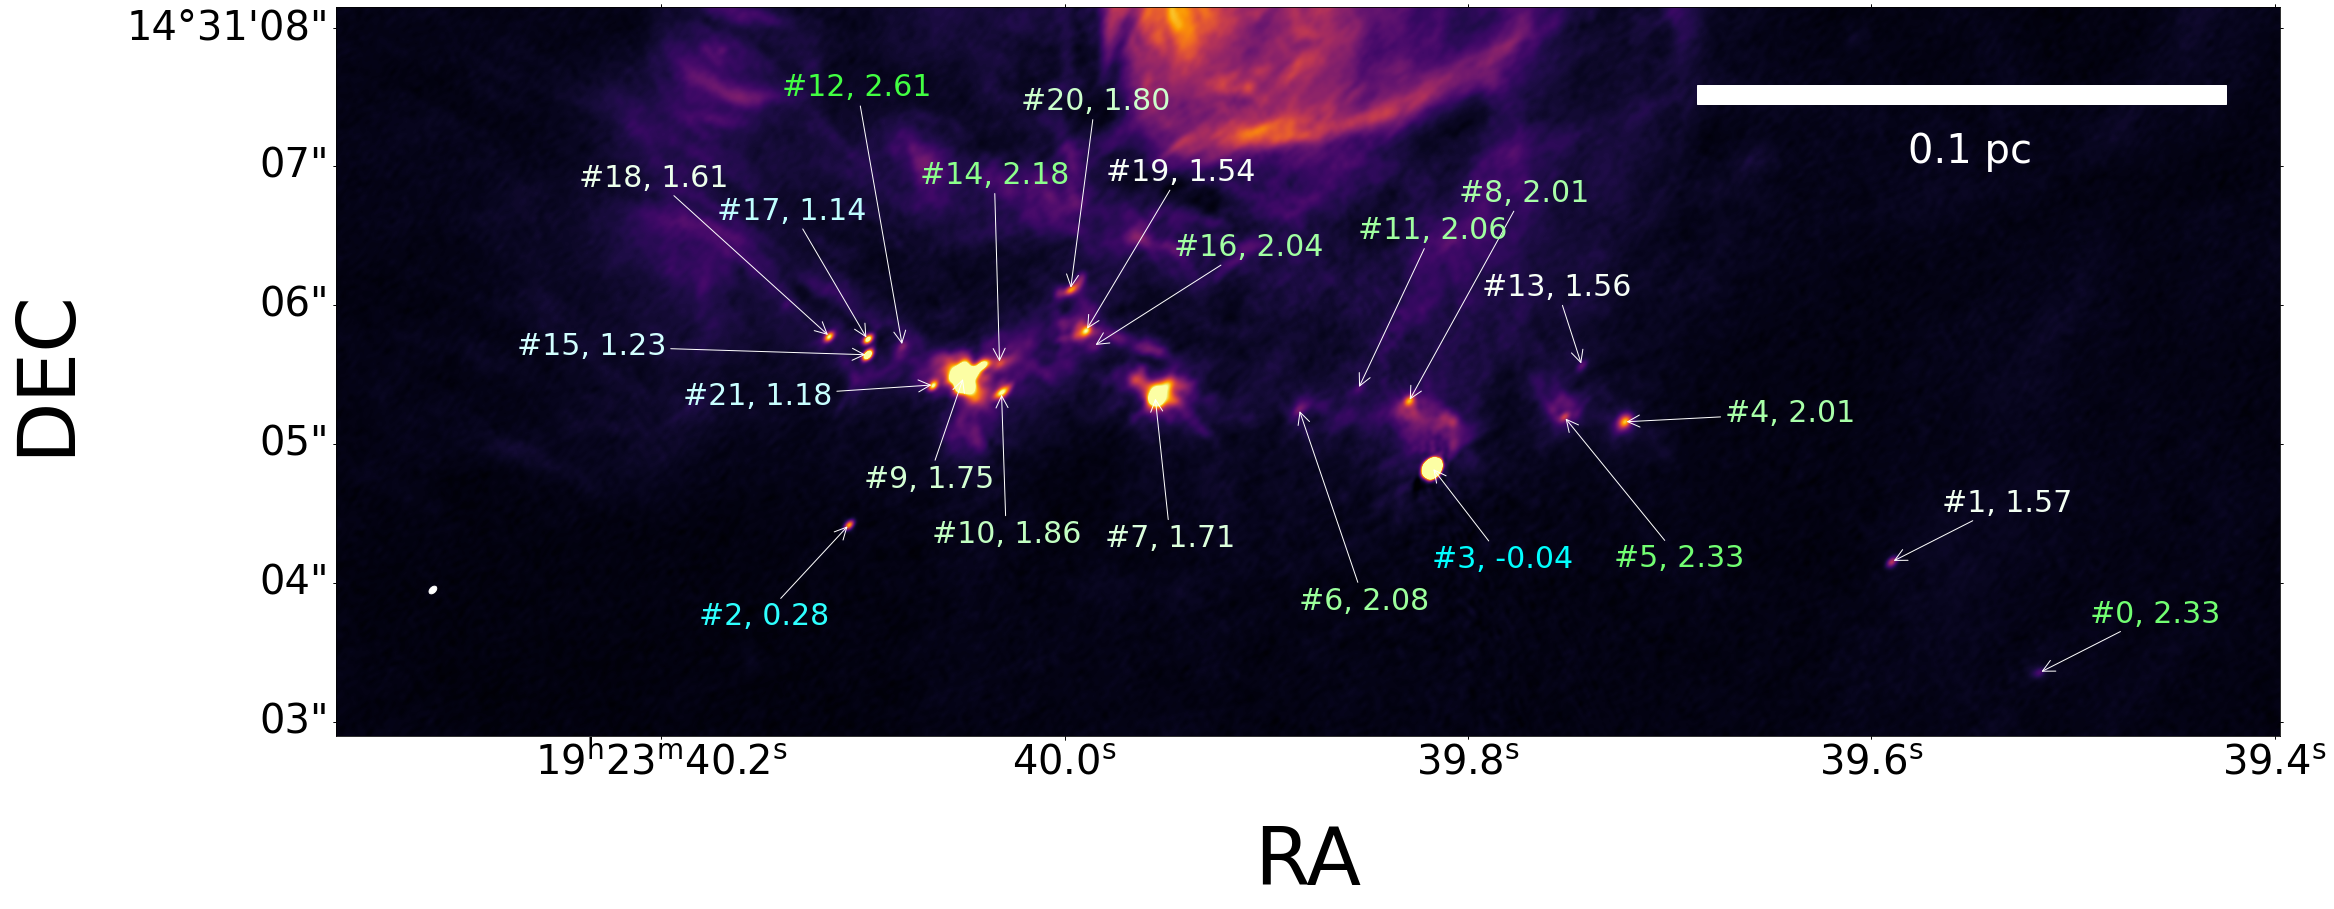

In [7]:
plt.rcParams['axes.labelsize']=80
plt.rcParams['xtick.labelsize']=40
plt.rcParams['ytick.labelsize']=40
plt.rcParams['axes.titlesize']=80
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.patches import Rectangle, Ellipse

def plot_peak(ax,image,xpos,ypos,size=20,labelind=None,labeltext=None,xtextpos=None,ytextpos=None,boxcolor=None,mark=False):
    cmap = cm.YlGn
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['cyan',"w","lime"])
    norm = mpl.colors.Normalize(vmin=0, vmax=3)
    
    
    if mark:
        ax.scatter(xpos,ypos, marker='x', c='cyan',s=size)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in range(len(labelind)):
        if boxcolor is not None:
            ax.annotate("#%d, %3.2f"%(i,labelind[i]),bbox=dict(facecolor='none',edgecolor=boxcolor),xy=(xpos[i],ypos[i]), xycoords='data', textcoords='offset pixels',
                    arrowprops=dict(arrowstyle="->",ec='w',fc='w'),xytext=(xtextpos[i],ytextpos[i]),fontsize=30,color=m.to_rgba(labelind[i]))
        else:
            
            ax.annotate("#%d, %3.2f"%(i,labelind[i]),xy=(xpos[i],ypos[i]), xycoords='data', textcoords='offset pixels',
                    arrowprops=dict(arrowstyle="->",ec='w',fc='w'),xytext=(xtextpos[i],ytextpos[i]),fontsize=30,color=m.to_rgba(labelind[i]))
    
    
def add_scale_bar(ax, xpos,ypos,scale, pixel_scale, dist, unit='pc',height=20,color='w',pad=40,size=40):
    phy_pix_scale = pixel_scale.value * np.pi/180 * dist
    ax.add_patch(Rectangle((xpos,ypos),scale/phy_pix_scale,height,color=color))
    ax.text(xpos+0.4*scale/phy_pix_scale, ypos+pad, '%2.1f %s'%(scale, unit), color=color,fontsize=size)
                
def add_beam(ax,xpos,ypos,beam, pixel_scale,color='w'):
    width = beam.major / pixel_scale
    height = beam.minor /pixel_scale
    angle = beam.pa
    ax.add_patch(Ellipse((xpos,ypos),width.value,height.value,180-angle.value,color=color))

xtextpos1 = np.array([50, 50, -150,    0,  100,   
            50,    0,  -50,   50,  -100,  
            -70,     0,   -120, -100, -80,  
            -350, 80,  -150, -250, 20, 
            -50, -250])
ytextpos1 = np.array([50, 50, -100, -100,    0, 
            -150, -200, -150,  200,  -110, 
            -150, 150, 250, 70, 180,
            0,  90, 120,  150, 150,
            180, -20])
    
fitsdata_b3 = fits.open(w51n_b3_tt0)
hdrNB3 = fits.getheader(w51n_b3_tt0)  
wcsNB3 = WCS(hdrNB3,naxis=2)
scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.1,0.1,0.9,0.9],projection=wcsNB3)
imageb3 = fitsdata_b3[0].data[0][0]
ax1.imshow(imageb3, origin='lower',cmap=plt.get_cmap('inferno'),vmin=-0.000055507826955594655,vmax=0.002191274995850258)
#mark_dendrogram_results(ax1, image, source_object,custom_dendro,
#                           vmin=-0.00044910456346381985,vfmax=0.006639306914117084)
#mark_dendrogram_results(ax1, imageb3_cut, source_object_b3,custom_dendro_b3
#                           ,vmin=-0.00044910456346381985,vmax=0.006639306914117084)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True,rejectreject=False)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True)

xpos = table_b3['x_pix_b3']
ypos = table_b3['y_pix_b3']
alpha_b3 = table_b3['alpha']
ismatched = table_b3['ismatched_b3']
plot_peak(ax1,imageb3,xpos,ypos,size=40,labelind=alpha_b3,xtextpos=xtextpos1,ytextpos=ytextpos1)

"""
ind = np.where(ismatched==True)[0]
print(len(ind),len(xtextpos1))
plot_peak(ax1,imageb3,xpos[ind],ypos[ind],size=40,labelind=alpha_b3[ind],xtextpos=xtextpos1[ind],ytextpos=ytextpos1[ind])

ind2 = np.where(ismatched==False)[0]
plot_peak(ax1,imageb3,xpos[ind2],ypos[ind2],size=40,labelind=alpha_b3[ind2],xtextpos=xtextpos1[ind],ytextpos=ytextpos1[ind],boxcolor='r')
"""
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
#ax1.set_xlim(5500,8500)
#ax1.set_ylim(6950,7700)
ax1.set_xlim(6500,8500)
ax1.set_ylim(6950,7700)
my_beamNB3 = Beam.from_fits_header(hdrNB3)
add_scale_bar(ax1, 7900,7600,0.1,scaleNB3,5.41e3,pad=-60)
add_beam(ax1,6600,7100,my_beamNB3, scaleNB3)
plt.savefig('dendroimage_w51n.png')

plt.show()


In [8]:

skycoord1 = wcsNB3.pixel_to_world(6500,7000)
skycoord2 = wcsNB3.pixel_to_world(8500,8000)
print(skycoord1,skycoord2)



<SkyCoord (ICRS): (ra, dec) in deg
    (290.9181731, 14.51756944)> <SkyCoord (ICRS): (ra, dec) in deg
    (290.91415592, 14.51951388)>


major 110.62698468653628
major 103.155556115106
major 149.14127040083076
major 111.76984182939368
major 122.98412754368196
major 158.12698468654716
major 151.9269846865457
major 148.18412754368774
major 144.61269897225833
major 157.48412754368985
major 115.31269897225164
major 164.04127040083418
major 268.898413258001
major 218.32698468656088
major 154.1269846865462
major 226.6126989722771
major 178.1841275436946
major 131.2412704008267
major 326.0412704008712
major 332.32698468658697
major 242.61269897228073
major 239.8984132579944
major 221.61269897227592
major 107.34127040082123
major 302.8984132580088
major 192.89841325798366


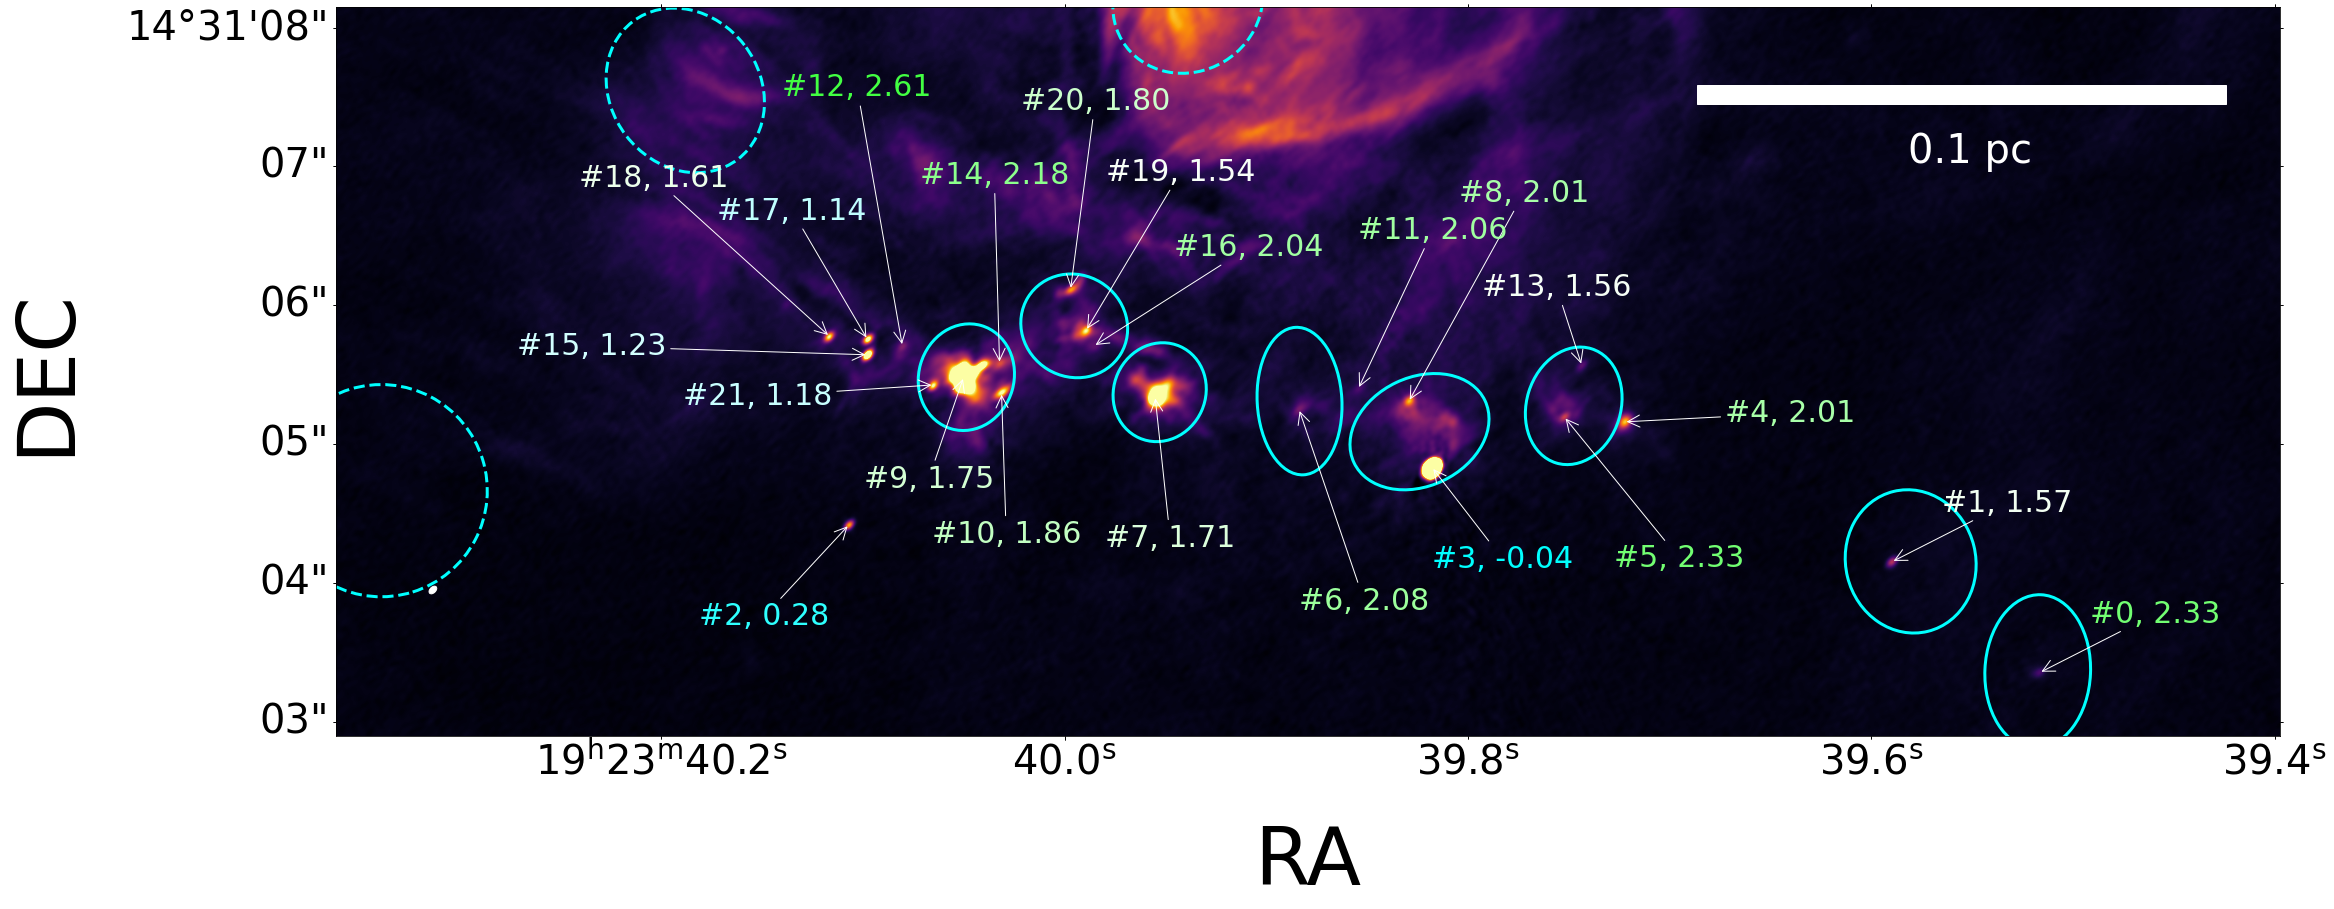

In [9]:
from astropy.io import ascii
w51n_b3_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_12M_robust0_selfcal4_finaliter.image.tt0.pbcor.fits'
w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'
w51e_b3_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'
w51e_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-E_B6_uid___A001_X1296_X213_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'

def plot_catalog_on_image(ax,image,hdrNB,catdatadir,band='B6',beam=None, 
                          label=None,color='cyan',lw=2,aperture='fwhm+beam',xysource=None, skip_image_plot=False, ls='solid'):
    catdata = ascii.read(catdatadir,data_start=0,format='commented_header', header_start=120,  comment="!")
    sky_ra = catdata['WCS_ACOOR']
    sky_dec = catdata['WCS_DCOOR']
    no = catdata['NO']
    if band=='B3':
        bandlabel = '03'
    elif band=='B6':
        bandlabel = '02'
    fooa = catdata['FOOA%s'%bandlabel]
    foob = catdata['FOOB%s'%bandlabel]
    theta = catdata['THETA%s'%bandlabel]
    afwhm = catdata['AFWHM%s'%bandlabel]
    bfwhm = catdata['BFWHM%s'%bandlabel]
   
    
    
    if label is not None:
        sky_ra= sky_ra[label]
        sky_dec = sky_dec[label]
        fooa = fooa[label]
        foob = foob[label]
        theta = theta[label]
        no = no[label]
        afwhm = afwhm[label]
        bfwhm = bfwhm[label]

    skypos = np.vstack((sky_ra,sky_dec)).T

    
    wcsNB = WCS(hdrNB,naxis=2)
    scaleNB = wcsNB.proj_plane_pixel_scales()[0]
    beamNB = Beam.from_fits_header(hdrNB)

    if not skip_image_plot:
        image = fitsdata[0].data[0][0]
        ax1.imshow(image, origin='lower',cmap=plt.get_cmap('inferno'),vmin=vmin,vmax=vmax)

    xypos = wcsNB.wcs_world2pix(skypos,0)
    xpos = xypos[:,0]
    ypos = xypos[:,1]
    
    
        
    indexlist = []
    for i in range(len(xypos)):
        if aperture is 'footprint':
            major = fooa[i]/3600/scaleNB.value
            minor = foob[i]/3600/scaleNB.value
            pa = 180-theta[i]
        elif aperture is 'fwhm+beam':
            meanbeamsize = (beam.major.value+beam.minor.value)/4
            major = (afwhm[i]/3600+meanbeamsize)/scaleNB.value
            minor = (bfwhm[i]/3600+meanbeamsize)/scaleNB.value
            pa = 180-theta[i]
            print('major',major)
        elif aperture is 'beam':
            major = beam.major.value/scaleNB.value
            minor = beam.minor.value/scaleNB.value
            pa = 180-beam.pa.value
    
        ellipse = Ellipse(xypos[i],width=major,height=minor,facecolor='none',
                          angle=180-pa,edgecolor=color,lw=lw,ls=ls)
        
        ax.add_patch(ellipse)

w51n_cat_almaimf = Table.read('../comparison/alma_imf_on_the_img_w51n.fits',format='fits')
w51n_almaimf_ind = w51n_cat_almaimf['index']
nofragments = np.where(w51n_cat_almaimf['fragments']<1)[0]
yesfragments = np.where(w51n_cat_almaimf['fragments']>=1)[0]


fitsdata_b3 = fits.open(w51n_b3_tt0)
hdrNB3 = fits.getheader(w51n_b3_tt0)  
wcsNB3 = WCS(hdrNB3,naxis=2)
scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.1,0.1,0.9,0.9],projection=wcsNB3)
imageb3 = fitsdata_b3[0].data[0][0]
ax1.imshow(imageb3, origin='lower',cmap=plt.get_cmap('inferno'),vmin=-0.000055507826955594655,vmax=0.002191274995850258)
#mark_dendrogram_results(ax1, image, source_object,custom_dendro,
#                           vmin=-0.00044910456346381985,vfmax=0.006639306914117084)
#mark_dendrogram_results(ax1, imageb3_cut, source_object_b3,custom_dendro_b3
#                           ,vmin=-0.00044910456346381985,vmax=0.006639306914117084)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True,rejectreject=False)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True)
catalogdir = '/orange/adamginsburg/ALMA_IMF/catalogs/getsf-smoothed/'
cat_w51e = catalogdir + 'W51-E-getsf.cat'
cat_w51n = catalogdir + 'W51-IRS2-getsf.cat'


hdr_almaimf_b3 = fits.getheader(w51n_b3_almaimf)
beam_almaimf_b3 = Beam.from_fits_header(hdr_almaimf_b3)
plot_catalog_on_image(ax1,imageb3,hdrNB3,cat_w51n,band='B3',beam=beam_almaimf_b3, 
                          label=w51n_almaimf_ind[yesfragments] ,color='cyan',lw=3,skip_image_plot=True, ls='solid')
plot_catalog_on_image(ax1,imageb3,hdrNB3,cat_w51n,band='B3',beam=beam_almaimf_b3, 
                          label=w51n_almaimf_ind[nofragments] ,color='cyan',lw=3,skip_image_plot=True, ls='dashed')

xpos = table_b3['x_pix_b3']
ypos = table_b3['y_pix_b3']
alpha_b3 = table_b3['alpha']
ismatched = table_b3['ismatched_b3']
plot_peak(ax1,imageb3,xpos,ypos,size=40,labelind=alpha_b3,xtextpos=xtextpos1,ytextpos=ytextpos1)


"""
ind = np.where(ismatched==True)[0]
print(len(ind),len(xtextpos1))
plot_peak(ax1,imageb3,xpos[ind],ypos[ind],size=40,labelind=alpha_b3[ind],xtextpos=xtextpos1[ind],ytextpos=ytextpos1[ind])

ind2 = np.where(ismatched==False)[0]
plot_peak(ax1,imageb3,xpos[ind2],ypos[ind2],size=40,labelind=alpha_b3[ind2],xtextpos=xtextpos1[ind],ytextpos=ytextpos1[ind],boxcolor='r')
"""

ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
#ax1.set_xlim(5500,8500)
#ax1.set_ylim(6950,7700)
ax1.set_xlim(6500,8500)
ax1.set_ylim(6950,7700)
my_beamNB3 = Beam.from_fits_header(hdrNB3)
add_scale_bar(ax1, 7900,7600,0.1,scaleNB3,5.41e3,pad=-60)
add_beam(ax1,6600,7100,my_beamNB3, scaleNB3)
plt.savefig('dendroimage_w51n.png')

plt.show()

        
        
        

<SkyCoord (ICRS): (ra, dec) in deg
    (290.9181731, 14.51747222)>
(array(5095.2106631), array(5479.99912272)) (array(7895.20970593), array(6530.00167505))
(array(479.90996844), array(560.19214693)) (array(619.9101503), array(612.69166201))


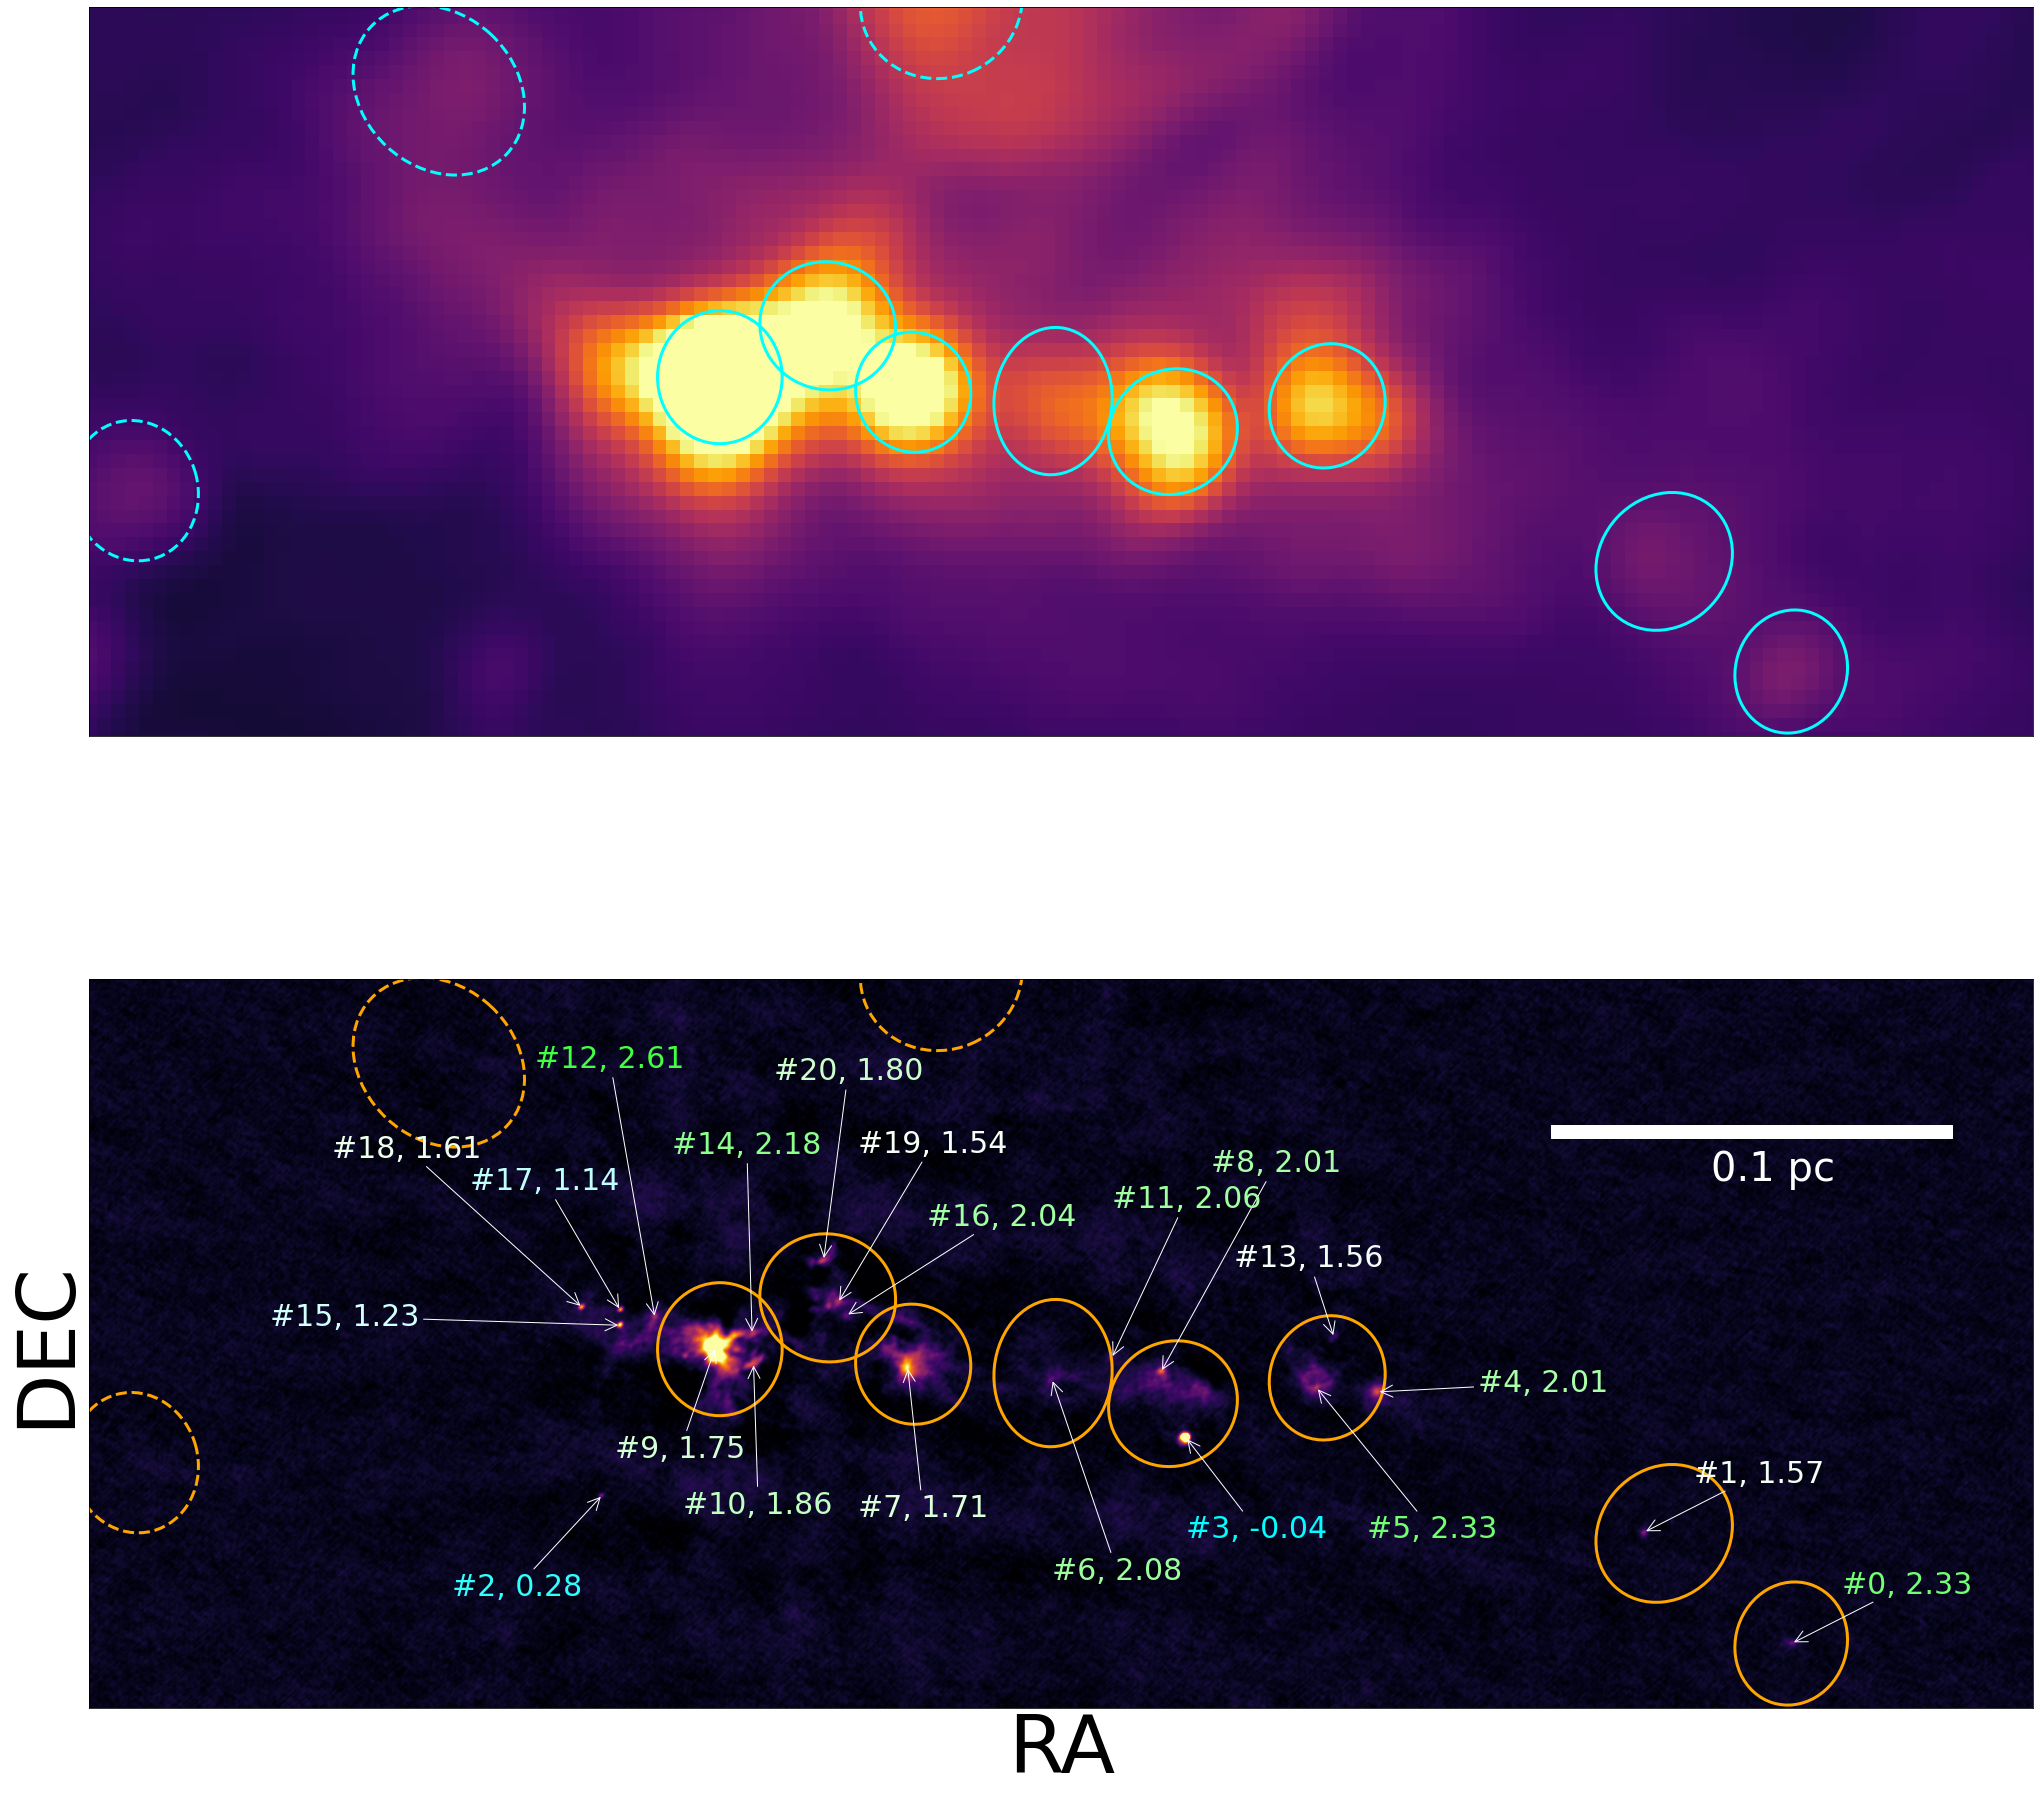

In [10]:
from astropy.io import ascii
from matplotlib import colors
w51n_b3_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B3_uid___A001_X1296_X18f_continuum_merged_12M_robust0_selfcal4_finaliter.image.tt0.pbcor.fits'
w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'
w51e_b3_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-E_B3_uid___A001_X1296_X10b_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'
w51e_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-E_B6_uid___A001_X1296_X213_continuum_merged_12M_robust0_selfcal7_finaliter.image.tt0.pbcor.fits'

def plot_catalog_on_image(ax,image,hdrNB,catdatadir,band='B6',beam=None, 
                          label=None,color='cyan',lw=2,aperture='fwhm+beam',xysource=None, skip_image_plot=False, ls='solid'):
    catdata = ascii.read(catdatadir,data_start=0,format='commented_header', header_start=120,  comment="!")
    sky_ra = catdata['WCS_ACOOR']
    sky_dec = catdata['WCS_DCOOR']
    no = catdata['NO']
    if band=='B3':
        bandlabel = '03'
    elif band=='B6':
        bandlabel = '02'
    fooa = catdata['FOOA%s'%bandlabel]
    foob = catdata['FOOB%s'%bandlabel]
    theta = catdata['THETA%s'%bandlabel]
    afwhm = catdata['AFWHM%s'%bandlabel]
    bfwhm = catdata['BFWHM%s'%bandlabel]
   
    
    
    if label is not None:
        sky_ra= sky_ra[label]
        sky_dec = sky_dec[label]
        fooa = fooa[label]
        foob = foob[label]
        theta = theta[label]
        no = no[label]
        afwhm = afwhm[label]
        bfwhm = bfwhm[label]

    skypos = np.vstack((sky_ra,sky_dec)).T

    
    wcsNB = WCS(hdrNB,naxis=2)
    scaleNB = wcsNB.proj_plane_pixel_scales()[0]
    beamNB = Beam.from_fits_header(hdrNB)

    if not skip_image_plot:
        image = fitsdata[0].data[0][0]
        ax1.imshow(image, origin='lower',cmap=plt.get_cmap('inferno'),vmin=vmin,vmax=vmax)

    xypos = wcsNB.wcs_world2pix(skypos,0)
    xpos = xypos[:,0]
    ypos = xypos[:,1]
    
    
        
    indexlist = []
    for i in range(len(xypos)):
        if aperture is 'footprint':
            major = fooa[i]/3600/scaleNB.value
            minor = foob[i]/3600/scaleNB.value
            pa = 180-theta[i]
        elif aperture is 'fwhm+beam':
            meanbeamsize = (beam.major.value+beam.minor.value)/4
            major = (afwhm[i]/3600+meanbeamsize)/scaleNB.value
            minor = (bfwhm[i]/3600+meanbeamsize)/scaleNB.value
            pa = 180-theta[i]
        elif aperture is 'beam':
            major = beam.major.value/scaleNB.value
            minor = beam.minor.value/scaleNB.value
            pa = 180-beam.pa.value
    
        ellipse = Ellipse(xypos[i],width=major,height=minor,facecolor='none',
                          angle=180-pa,edgecolor=color,lw=lw,ls=ls)
        
        ax.add_patch(ellipse)

w51n_cat_almaimf = Table.read('../comparison/alma_imf_on_the_img_w51n.fits',format='fits')
w51n_almaimf_ind = w51n_cat_almaimf['index']
nofragments = np.where(w51n_cat_almaimf['fragments']<1)[0]
yesfragments = np.where(w51n_cat_almaimf['fragments']>=1)[0]

fitsdata_almaimf_b6 = fits.open(w51n_b6_almaimf)
image_almaimf_b6 = fitsdata_almaimf_b6[0].data[0][0]
hdr_almaimf_b6 = fits.getheader(w51n_b6_almaimf)
wcs_almaimf_b6 = WCS(hdr_almaimf_b6,naxis=2)
beam_almaimf_b6 = Beam.from_fits_header(hdr_almaimf_b6)


fitsdata_b6 = fits.open(w51n_b6_briggs)
hdrNB6 = fits.getheader(w51n_b6_briggs)  
wcsNB6 = WCS(hdrNB6,naxis=2)
scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.1,0.1,0.9,0.45])
ax2 = fig.add_axes([0.1,0.55,0.9,0.45])

imageb6 = fitsdata_b6[0].data[0][0]

ax1.imshow(imageb6, origin='lower',cmap=plt.get_cmap('inferno'),vmin=-0.00044910456346381985,vmax=0.008041974000295781)
#mark_dendrogram_results(ax1, image, source_object,custom_dendro,
#                           vmin=-0.00044910456346381985,vfmax=0.006639306914117084)
#mark_dendrogram_results(ax1, imageb3_cut, source_object_b3,custom_dendro_b3
#                           ,vmin=-0.00044910456346381985,vmax=0.006639306914117084)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True,rejectreject=False)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True)
catalogdir = '/orange/adamginsburg/ALMA_IMF/catalogs/getsf-smoothed/'
cat_w51e = catalogdir + 'W51-E-getsf.cat'
cat_w51n = catalogdir + 'W51-IRS2-getsf.cat'



plot_catalog_on_image(ax1,imageb6,hdrNB6,cat_w51n,band='B6',beam=beam_almaimf_b6, 
                          label=w51n_almaimf_ind[yesfragments] ,color='orange',lw=3,skip_image_plot=True, ls='solid')
plot_catalog_on_image(ax1,imageb6,hdrNB6,cat_w51n,band='B6',beam=beam_almaimf_b6, 
                          label=w51n_almaimf_ind[nofragments] ,color='orange',lw=3,skip_image_plot=True, ls='dashed')

xpos = table_b6['x_pix_b6']
ypos = table_b6['y_pix_b6']
alpha_b6 = table_b6['alpha']
ismatched = table_b3['ismatched_b3']
plot_peak(ax1,imageb6,xpos,ypos,size=40,labelind=alpha_b6,xtextpos=xtextpos1,ytextpos=ytextpos1)


"""
ind = np.where(ismatched==True)[0]
print(len(ind),len(xtextpos1))
plot_peak(ax1,imageb3,xpos[ind],ypos[ind],size=40,labelind=alpha_b3[ind],xtextpos=xtextpos1[ind],ytextpos=ytextpos1[ind])

ind2 = np.where(ismatched==False)[0]
plot_peak(ax1,imageb3,xpos[ind2],ypos[ind2],size=40,labelind=alpha_b3[ind2],xtextpos=xtextpos1[ind],ytextpos=ytextpos1[ind],boxcolor='r')
"""

ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
#ax1.set_xlim(5500,8500)
#ax1.set_ylim(6950,7700)
#ax1.set_xlim(6500,8500)
#ax1.set_ylim(6950,7700)
sky1 = wcsNB3.pixel_to_world(6500,6950)
sky2 = wcsNB3.pixel_to_world(8500,7700)
print(sky1)
def auto_scale_lim(ax, sky1,sky2, WCShdr):
    pixpos1 = WCShdr.world_to_pixel(sky1)
    pixpos2 = WCShdr.world_to_pixel(sky2)
    
    ax.set_xlim(pixpos1[0],pixpos2[0])
    ax.set_ylim(pixpos1[1],pixpos2[1])
    print(pixpos1,pixpos2)
add_scale_bar(ax1, 7200,6300,0.1,scaleNB3,5.1e3,pad=-60)
    
auto_scale_lim(ax1,sky1,sky2,wcsNB6)
#my_beamNB3 = Beam.from_fits_header(hdrNB3)
#add_scale_bar(ax1, 7900,7600,0.1,scaleNB3,5.41e3,pad=-60)
#add_beam(ax1,6600,7100,my_beamNB3, scaleNB3)
#plt.savefig('dendroimage_w51n.png')

ax2.imshow(image_almaimf_b6, origin='lower',cmap=plt.get_cmap('inferno'),norm=colors.PowerNorm(gamma=0.5,vmin=-0.0021462059082253933,vmax=0.2495768162809554))
plot_catalog_on_image(ax2,image_almaimf_b6,hdr_almaimf_b6,cat_w51n,band='B6',beam=beam_almaimf_b6, 
                          label=w51n_almaimf_ind[yesfragments] ,color='cyan',lw=3,skip_image_plot=True, ls='solid')
plot_catalog_on_image(ax2,image_almaimf_b6,hdr_almaimf_b6,cat_w51n,band='B6',beam=beam_almaimf_b6, 
                          label=w51n_almaimf_ind[nofragments] ,color='cyan',lw=3,skip_image_plot=True, ls='dashed')

auto_scale_lim(ax2,sky1,sky2,wcs_almaimf_b6)
ax2.set_xticks([])
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_yticks([])
plt.show()

        
        
        